# 1. Imports

In [2]:
# !pip install adversarial-robustness-toolbox

In [3]:
import numpy as np
import math
from random import random, randint

import pandas as pd
import seaborn as sns

from matplotlib import pyplot as plt

from tensorflow.keras.models import load_model
from tensorflow.keras.layers import Softmax

from gurobipy import *

import os
import warnings
warnings.filterwarnings('ignore')
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

# 2. Compute statistical metrics

In [4]:
ACAS_labels = ["COC","WR","WL","SR","SL"]

## 1 - Load the ACAS model

In [5]:
def load_ACAS(num_net, folder="ACAS_XU_tf_keras/"):
    if (num_net[0] in range(1,6)) and (num_net[1] in range(1,10)):
        path_model = folder + "ACASXU_{}_{}.h5".format(num_net[0], num_net[1])
        model = load_model(path_model)
        model.compile()
    else:
        raise Exception("ACAS neural network {0}-{1} doesn't exist.".format(num_net[0],num_net[1]))
    
    return model

## 2 - Compute manually the output of each layer on the initial point

In [6]:
def compute_layers(model,x_):
    y_=[[]]
    for j in range(model.layers[0].weights[0].shape[1]):
        z=0
        for k in range(model.layers[0].weights[0].shape[0]):
            z+=model.layers[0].weights[0][k][j]* x_[k]
        z+=model.layers[0].weights[1][j]
        y_[0].append(z)

    for i in range(1,len(model.layers)-1): # We skip last layer (softmax)
        y_.append([])
        if model.layers[i].__class__.__name__=='Activation':
            for j in range(len(y_[i-1])):
                if y_[i-1][j]<0:
                    y_[i].append(0)
                else:
                    y_[i].append(y_[i-1][j])
        elif model.layers[i].__class__.__name__=='Dense':
            for j in range(model.layers[i].weights[0].shape[1]):
                z=0
                for k in range(model.layers[i].weights[0].shape[0]):
                    z+=model.layers[i].weights[0][k][j]* y_[i-1][k]
                z+=model.layers[i].weights[1][j]
                y_[i].append(z)
    
    # 3 - Verify that the result is the same as the answer of the network
    
    #pdb.set_trace()
    #model.summary()
    # print(model.predict(np.expand_dims(x_, axis=0)))
    # lastLayer = Softmax()
    # print(lastLayer(y_[-1]).numpy())
    
    return y_

## 4- Use linear programming to compute the approximation of epsilon

In [7]:
def compute_epsilon(x_, y_, l, model):
    """Do not forget to set folder and, if you use Colab, to import your neural networks!"""
    
    # 1 - Create model and variables
    
    m = Model("rho")
    t=m.addVar(lb=0.0, ub=float('inf'), obj=0.0, vtype=GRB.CONTINUOUS, name = f't')
    x=[m.addVar(lb=-float('inf'), ub=float('inf'), vtype=GRB.CONTINUOUS, name = f'x_{i}') for i in range(len(x_))]
    y=[[m.addVar(lb=-float('inf'), ub=float('inf'), vtype=GRB.CONTINUOUS, name = f'y_{i}_{j}') for j in range(len(y_[i]))] for i in range(len(model.layers)-1)]


    # 2 - Add constraints

    # 2.1 - Constraint |x-x_|oo<=t
    for i in range(len(x_)):
        m.addConstr(x[i]-x_[i] <= t)
        m.addConstr(-x[i]+x_[i] <= t)

    # 2.2 - Neural Network Constraint
    for j in range(model.layers[0].weights[0].shape[1]):
        z=LinExpr()
        for k in range(model.layers[0].weights[0].shape[0]):
            z+=model.layers[0].weights[0][k][j]* x[k]
        z+=model.layers[0].weights[1][j]
        m.addConstr(y[0][j] == z)

    for i in range(1,len(model.layers)-1): #Skip last layer (softmax)
        if model.layers[i].__class__.__name__=='Activation':
            for j in range(len(y_[i-1])):
                if y_[i-1][j]<0:
                    m.addConstr(y[i][j] == 0)
                else:
                    m.addConstr(y[i][j] == y[i-1][j])
        elif model.layers[i].__class__.__name__=='Dense':
            for j in range(model.layers[i].weights[0].shape[1]):
                z=LinExpr()
                for k in range(model.layers[i].weights[0].shape[0]):
                    z+=model.layers[i].weights[0][k][j]* y[i-1][k]
                z+=model.layers[i].weights[1][j]
                m.addConstr(y[i][j] == z)

    # 2.3 - Target output label
    for i in range(len(y[-1])):
        if i != l:
            m.addConstr(y[-1][i]<=y[-1][l])

    # 3 - Objective : minimise distance to inital point
    
    m.setObjective(t, GRB.MINIMIZE)

    # 4 - Optimize

    m.params.outputflag = 0 # mute mode
    m.update()
    m.display()
    m.optimize()

    # 5 - Read result
    if  m.status == GRB.INFEASIBLE:
        # print("No solution !!")
        
        return float('inf')
    else:
        lastLayer = Softmax()
        # print("Point : ",x_," -> ",[z.x for z in x])
        # print("Scores : ",lastLayer(y_[-1]).numpy()," -> ",lastLayer([z.x for z in y[-1]]).numpy())
        # print("Objective : ",m.objVal)

        return m.objVal

## 4 - Compute rho (optimized to reduce calls to functions)

In [8]:
def compute_rho(X,model):
  R=[]
  k=0
  for x_ in X:
    k+=1
    R.append([])
    y_=compute_layers(model,x_)
    l=np.argmax(y_[-1])
    m=float('inf')
    for i in range(5):
      eps=compute_epsilon(x_, y_, i, model)
      R[-1].append(eps)
      if i!=l:
        m=min(m,eps)
    R[-1].append(m)
    print("Point n°",k," : ",R[-1])
  return R

## 5 - Compute metrics (optimized to reduce calls to functions)

In [9]:
def compute_metrics(R,eps):
  phi,mu=[0]*6,[0]*6
  for i in range(6):
    n=0
    for rho in R:
      if rho[i]<=eps:
        n+=1
        mu[i]+=rho[i]
  
    phi[i]=n/len(R)
    mu[i]/=max(n,1)

  return phi,mu

## 6 - Compute random points inside the domain

In [10]:
input_names = ['rho','theta','psi','v_own','v_int']

X_mean = np.array( [1.9791091*1e4, 0.0, 0.0, 650.0, 600.0] )
X_range = np.array( [60261.0, 6.28318530718, 6.28318530718, 1100.0, 1200.0] )
X_dom = np.array([ [0.0,    -np.pi, -np.pi, 100.0,     0.0],
                   [60760.0, np.pi,  np.pi, 1200.0, 1200.0] ])

inputs_domain = np.zeros((2,5))
inputs_domain[0,0] = (X_dom[0,0]-X_mean[0])/X_range[0]
inputs_domain[1,0] = (X_dom[1,0]-X_mean[0])/X_range[0]
for k in range(1,5):
    inputs_domain[0,k] = -0.5 ; inputs_domain[1,k] = 0.5

def create_random_pts(npts, boundaries=inputs_domain):
    """ Generate 'npts' random points in the domain defined by the 'boundaries'. """
    pts = np.random.rand(npts, 5)
    for f in range(0,5):
        pts[:,f] *= (boundaries[1][f] - boundaries[0][f])
        pts[:,f] += boundaries[0][f]
    return(pts)

## 7 - Main function

In [24]:
def networks_metrics(nets,nb_pts,nb_eps):
  #X=create_random_pts(nb_pts)
  nb_pts=min(1000,nb_pts)
  X = np.load('base_pts.npy')[:nb_pts]
  stats_phi,stats_mu=[np.zeros((len(nets),nb_eps)) for _ in range(6)],[np.zeros((len(nets),nb_eps)) for _ in range(6)]
  for i in range(len(nets)):
    num_net = nets[i]
    model = load_ACAS(num_net)
    R=compute_rho(X,model)
    for j in range(nb_eps):
      M=compute_metrics(R,1/2**j)
      for k in range(6):
        stats_phi[k][i,j]=M[0][k]
        stats_mu[k][i,j]=M[1][k]
  
  return stats_phi,stats_mu

# 3 - Plotting

Point n° 1  :  [0.022492661848691697, 0.05627359695578471, 0.03119495883410861, 0.0, 0.24207089213730087, 0.022492661848691697]
Point n° 2  :  [0.2739247759101351, 0.03565887838658688, 0.003027995417433149, 0.19979500960789962, 0.0, 0.003027995417433149]
Point n° 3  :  [0.0, inf, 0.11053582914127091, 0.24756450297015234, inf, 0.11053582914127091]
Point n° 4  :  [1.1141487846212657, 0.0, inf, 1.7609478987158949, 0.18572451652508198, 0.18572451652508198]
Point n° 5  :  [1.0278215038203773, 0.0, inf, 0.04079826886155207, 0.14544322278482982, 0.04079826886155207]
Point n° 6  :  [1.7272884957114385, 0.0, inf, 0.5799028820469355, 0.1967442230883698, 0.1967442230883698]
Point n° 7  :  [0.9650331915116467, 0.0, inf, 1.110672455253483, 0.22117369543419552, 0.22117369543419552]
Point n° 8  :  [0.735423008933843, 0.0, inf, 0.5306484391914188, 0.13398619660545497, 0.13398619660545497]
Point n° 9  :  [0.8005769121088522, 0.0, inf, 0.9439643495380178, 0.20729325469185989, 0.20729325469185989]
Point 

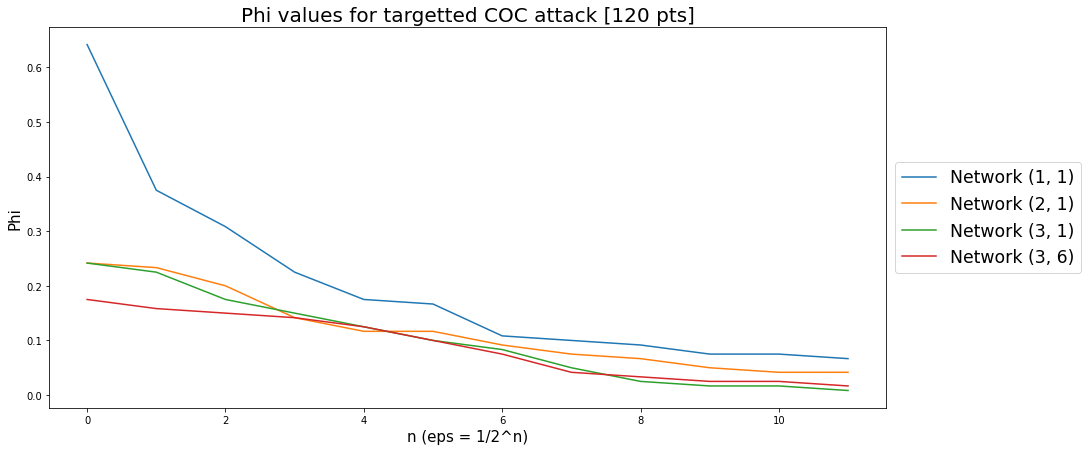

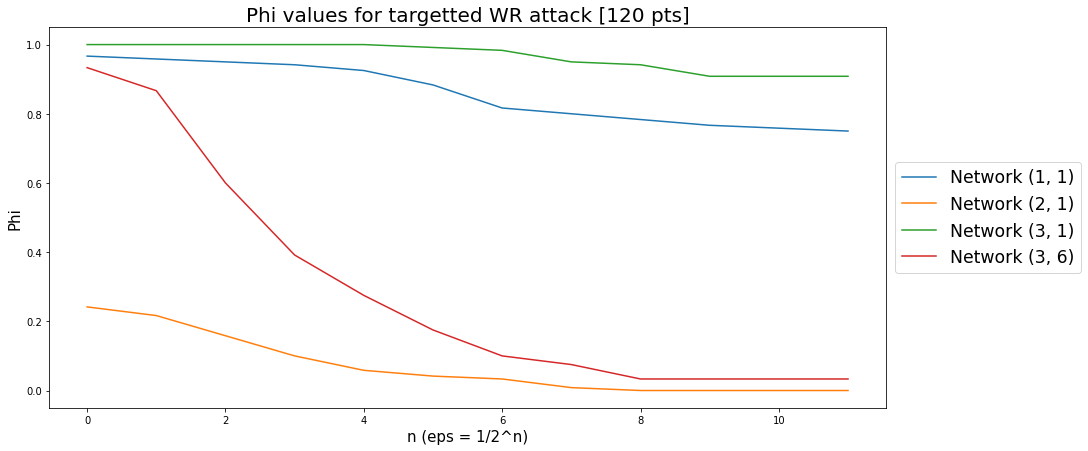

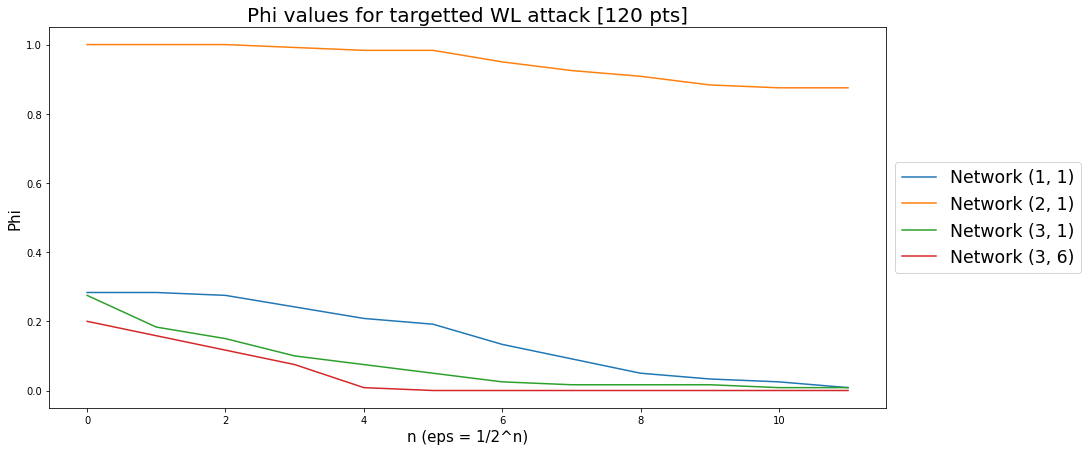

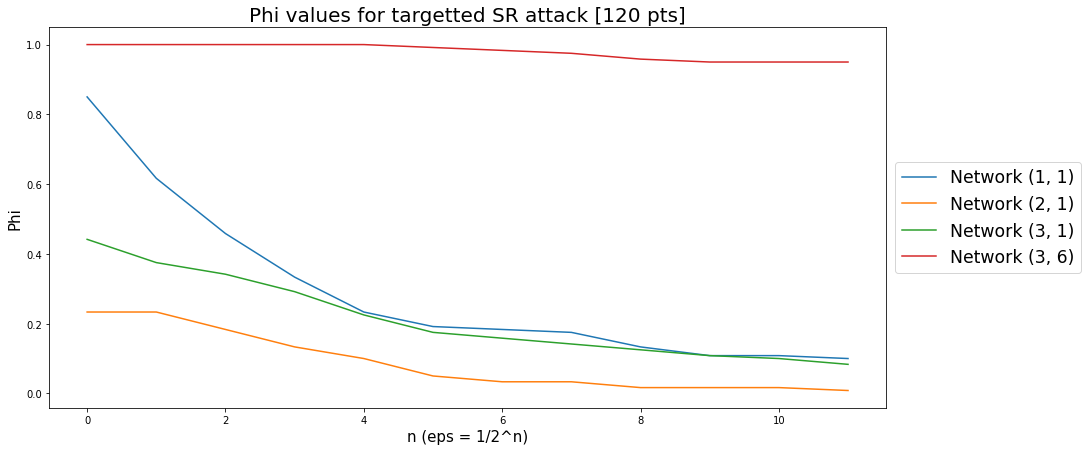

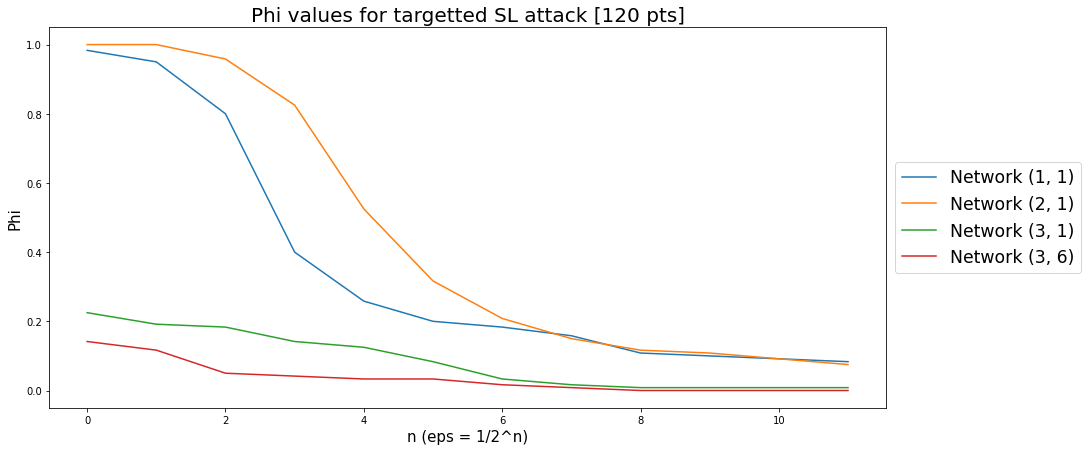

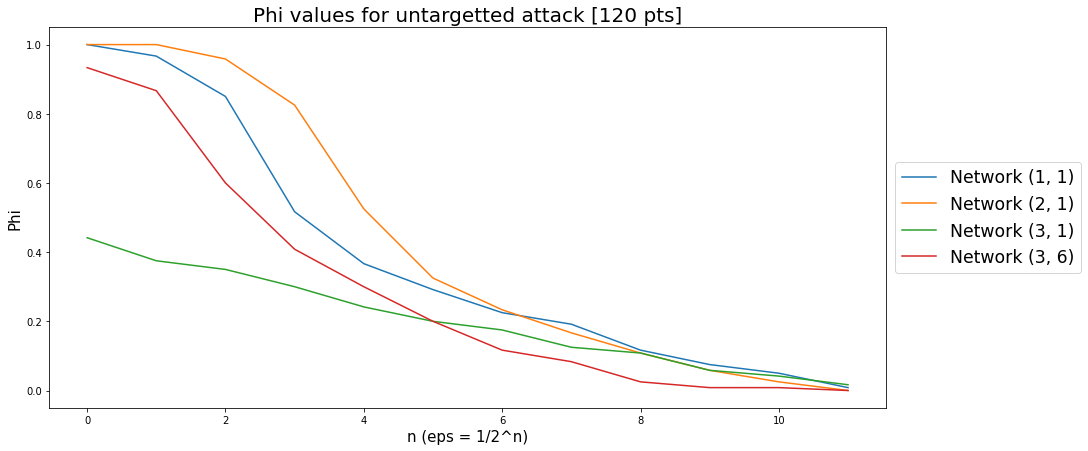

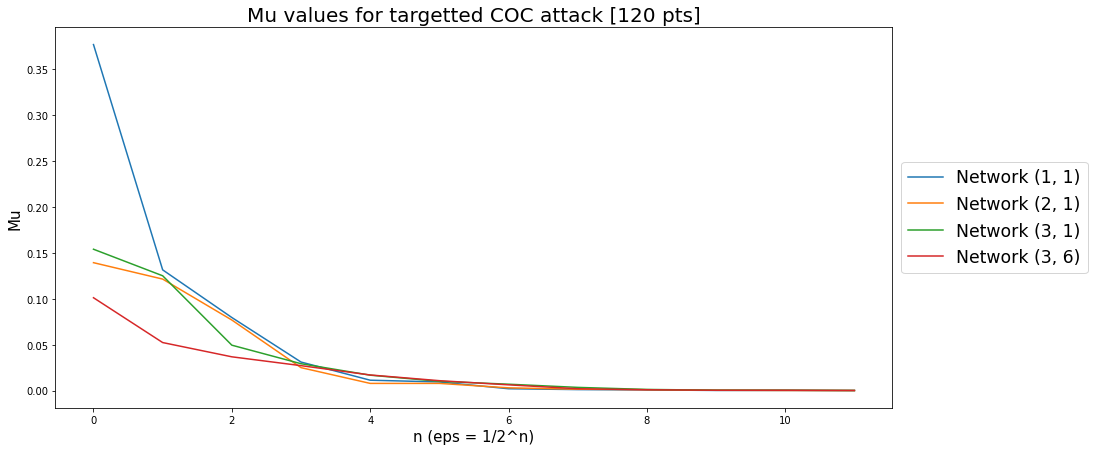

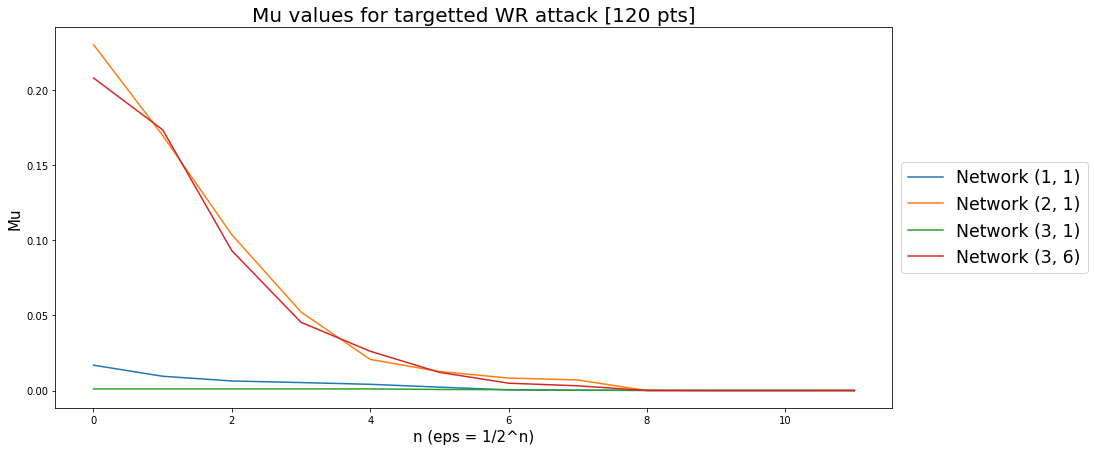

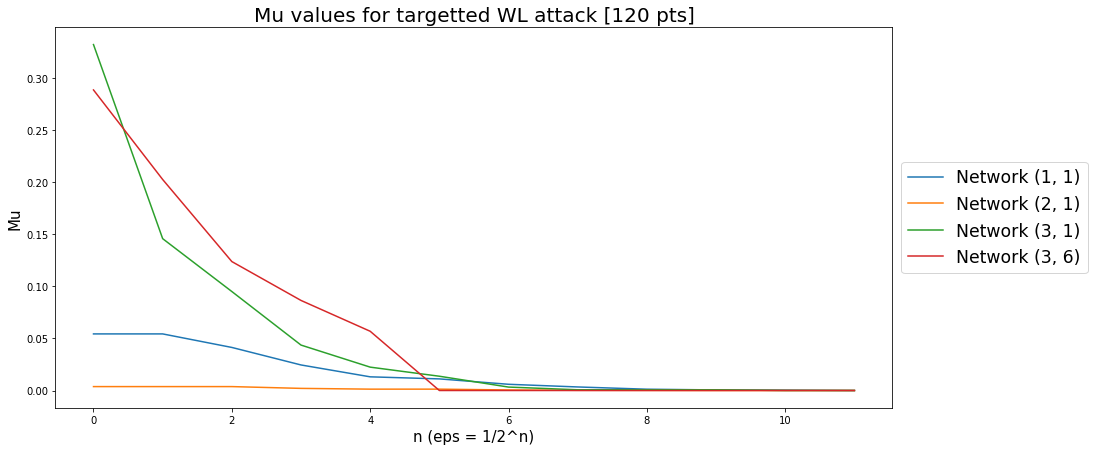

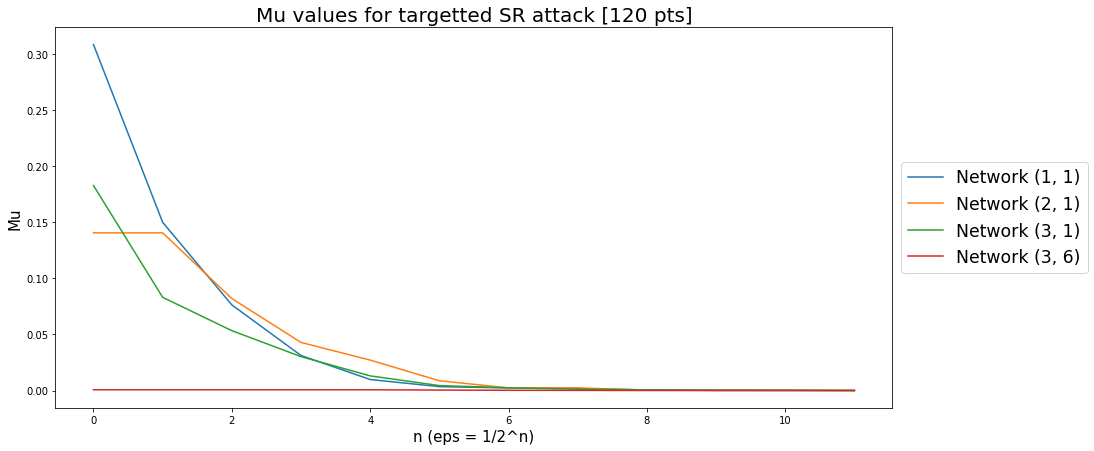

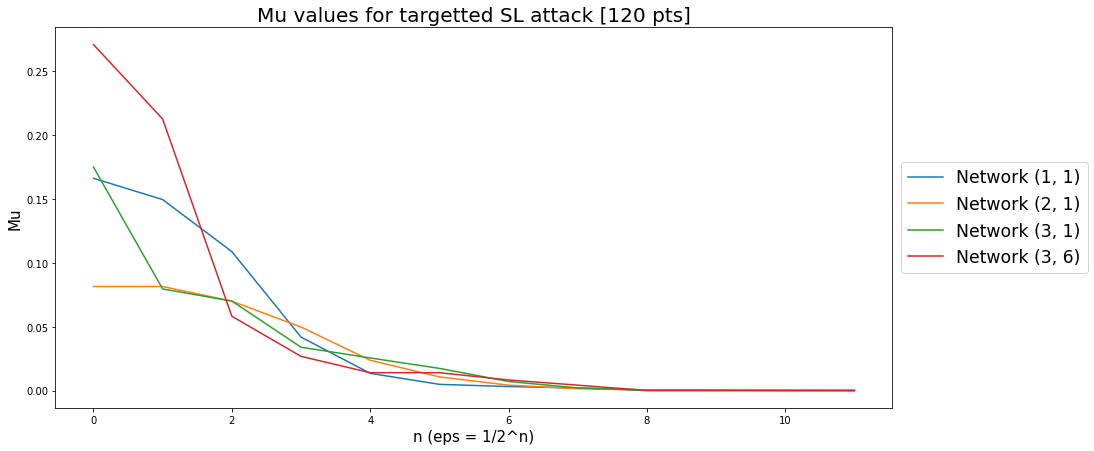

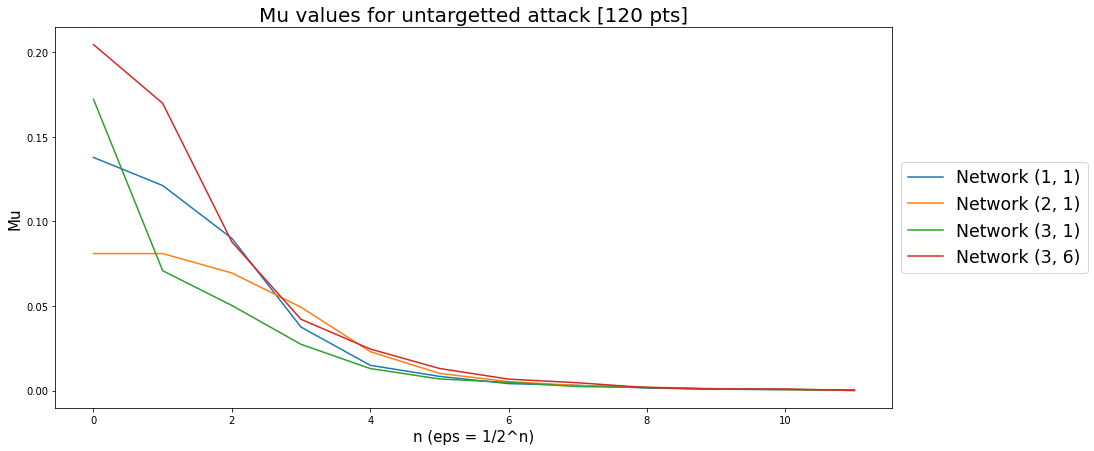

In [26]:
def plot_metrics(nets,nb_pts,nb_eps):
  stats = networks_metrics(nets,nb_pts,nb_eps)
  # print(stats)
  vars = ["Phi","Mu"]
  for i in range(2):
    for j in range(5):
      plt.figure(figsize = (15,7))
      for k in range(0,len(nets)):
        plt.plot([n for n in range(nb_eps)], stats[i][j][k,:], label="Network "+str(nets[k]))
      plt.xlabel("n (eps = 1/2^n)", size=15) ; plt.ylabel(vars[i], size=15)
      plt.title("{0} values for targeted {1} attack [{2} pts]".format(vars[i],ACAS_labels[j],nb_pts), size=20)
      plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize="xx-large")
      plt.savefig("metrics/"+str(nets[k])+str(vars[i])+str(ACAS_labels[j])+str(nb_pts))
    plt.figure(figsize = (15,7))
    for k in range(0,len(nets)):
      plt.plot([n for n in range(nb_eps)], stats[i][5][k,:], label="Network "+str(nets[k]))
    plt.xlabel("n (eps = 1/2^n)", size=15) ; plt.ylabel(vars[i], size=15)
    plt.title("{0} values for untargeted attack [{1} pts]".format(vars[i],nb_pts), size=20)
    plt.legend(loc='center left', bbox_to_anchor=(1, 0.5), fontsize="xx-large")
    plt.savefig("metrics/"+str(nets[k])+str(vars[i])+str("Untargeted")+str(nb_pts))

plot_metrics([(1,1), (2,1), (3,1), (3,6)],120,12)